# Pyquad
Owen Smith - GIS 712

---

## Package overview

This notebook shows how to use the Quadtree methods from the pyquad package which was written for this course.

First lets explore what is available within our QuadTree methods. Since this pyquad was written to be a standalone package, none of core functions will be defined within this notebook and instead will be imported from our source.

In [26]:
# Pretty printing because we are ✨quirky✨
%load_ext autoreload
%load_ext rich
from rich import inspect
from rich import print
###########################################

# Actual logic to import pyquad
# If cannot import local package then add parent dir to path
try:
    import pyquad # Import root so we can inspect full package
    from pyquad import RegionQuadTree, RegionNode
except ImportError:
    import sys
    sys.path.append("../")
    import pyquad
    from pyquad import RegionQuadTree, RegionNode

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rich extension is already loaded. To reload it, use:
  %reload_ext rich


Using the standard librarys `inspect` (also helpfully provided by the `rich` library) we can take a quick glance at all the methods and data structures which are defined within pyquad.

In [2]:
inspect(pyquad, help=True, methods=True)

╭────────────── <module 'pyquad' from '/Users/osmith2/src/pyquad/notebooks/../pyquad/__init__.py'> ───────────────╮
│ geometry_objects = <module 'pyquad.geometry_objects' from                                                       │
│                    '/Users/osmith2/src/pyquad/notebooks/../pyquad/geometry_objects.py'>                         │
│   point_quadtree = <module 'pyquad.point_quadtree' from                                                         │
│                    '/Users/osmith2/src/pyquad/notebooks/../pyquad/point_quadtree.py'>                           │
│  region_quadtree = <module 'pyquad.region_quadtree' from                                                        │
│                    '/Users/osmith2/src/pyquad/notebooks/../pyquad/region_quadtree.py'>                          │
│      BoundingBox = class BoundingBox(lx: 'int | float', rx: 'int | float', ty: 'int | float', by: 'int |        │
│                    float') -> None:                                                                             │
│                    Generic object to represent a bounding box with associated helper functions                  │
│                                                                                                                 │
│                    Parameters                                                                                   │
│                    ----------                                                                                   │
│                    lx : int | float                                                                             │
│                        Left most x coord                                                                        │
│                    rx : int | float                                                                             │
│                        Right most x coord                                                                       │
│                    ty : int | float                                                                             │
│                        Top y coord                                                                              │
│                    by : int | float                                                                             │
│                        bottom y coord                                                                           │
│                                                                                                                 │
│                    Attributes                                                                                   │
│                    ----------                                                                                   │
│                    mid : Point                                                                                  │
│                        Center point of bounding box                                                             │
│                                                                                                                 │
│                                                                                                                 │
│                    Class Methods                                                                                │
│                    -------------                                                                                │
│                    from_list(point_list: List[float | int])                                                     │
│                        Create BoundingBox object from list of [lx, rx, ty, by]                                  │
│                    from_numpy(array: np.ndarray[Any, Any])                                                      │
│                        Create BoundingBox object from Numpy array                                               │
│                                                       

the package contains two types of QuadTrees - Point and Region. For our purposes we will be focusing on the RegionQuadTree as we are interested on raster decomposition and not spatial querying. 

There are three key data structures defined
  - `BoundingBox`
  - `RegionNode`
  - & `RegionQuadTree`
  
The `BoundingBox` data structure provides a lot of the core functionality for storing the bounds of any given Node in our tree structure. By having a seperate object for the bounding box it allows us to abstract spatial managment away from our other objects and generate a more succient geometric representation. In other words, our node object does not need to know *how* to manipulate the geometry of our bounding box, only that it can. 

The `RegionNode` structure is our key individual structure for our tree. Each node within our tree will be made up of this structure and it stores the value assigned, location, and pointers to it's four children (if it has them, otherwise they will be `None`). The object does the work to split into children nodes, but *does not contain* the logic which is used to *decide when to split*. This isolates our object so that it can be as pure a representation of single node as possible. 

Our `RegionQuadTree` object is what interfaces with the two previous objects. This is called a component interface and ensures that both indivdual and composite objects (or types) can be treated in a unified manner. The `RegionQuadTree` is then what constructs a full quadtree and is what the user will interface with for actions such as traversal, storing, updating, etc. 

## Usage

Now lets see how the package can be used in practice

In [3]:
# Import libs to open data, plot, math stuff, etc

from pathlib import Path
import random

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
from numba import njit, jit
import numpy as np
import rasterio as rio
from scipy import ndimage
import scipy.signal

### Splitting criteria

First we need to define the splitting criteria we want to use so that the QuadTree knows when to keep/stop recursing. There are almost infinite options that we could use, but currently for our purposes we define our splitting critera as the following variation of the Symmetric Mean Absolute percentage error (sMAPE) as it has the desirable property of being bounded to $[0, 100]$. It is defined as follows, 
$$
sMAPE = 
\begin{cases}
0, & \text{ if } F_t = A_t = 0\\
\frac{100\%}{n}\sum_{t=1}^n\frac{|F_t - A_t|}{|A_t| + |F_t|}, & \text{ otherwise } \\
\end{cases}
$$
where $F_t$ and $A_t$ are the forecasted and actual value respectively. If $F_t = A_t = 0$ we simply assign zero Since we are trying to estimate how well the surface state at a given scale represents the data contained within that scale at it's raw resolution we assign $F_t$ as the mean of all data at that scale. 

In addition to our splitting criteria, we need to establish an acceptable threshold ($T$) with which to compare our sMAPE function against. This is where the bounding property of sMAPE comes in handy. Since our criteria can is in essence a mean error percentage, our threshold can be thought of as an acceptable amount of error allowed and can be denoted as, 

$$
\texttt{ quadtree }= 
\begin{cases}
\texttt{ split_Node(Node) }, & \text{ if } sMAPE > T\\\\
\texttt{ Node.val} = F_t , & \text{ otherwise } \\\\
\end{cases}
$$

The `RegionQuadTree` object accepts a user specified split criteria function where the input is type `np.ndarray[Any, Any]` and the output is `Union[float | int]`. We define our sMAPE function in python as 

In [4]:
@njit
def smape_numba(a):
    f = np.mean(a)  # The mean of the node will be the forecasted value
    mean_perc = 0.0
    for i in a.flatten():
        mean_perc += np.abs(f - i) / (np.abs(i) + np.abs(f))
    return 100 / a.size * mean_perc

We use [numba](https://numba.pydata.org/) which provides a Just In Time (JIT) compiler for python in addition to tranlasting the python functions to optimized machine code. It is particularly useful for numerical computation, and since our `smape` function will be computed an unkown number of times we can use any optimization we can get.  

### Applying to simulated data

We'll start first with some spatially correlated data just to get an idea of how it works and also just because it is fun. All the below function does is create an array of random noise and convolve it with a gaussian kernel. Nothing fancy but gets the job done 

In [5]:
def create_simultated_matrix(correlation_scale: int = 100, n: int = 1000):
    # https://stackoverflow.com/a/63868276
    # Compute filter kernel with radius correlation_scale (can probably be a bit smaller)
    x = np.arange(-correlation_scale, correlation_scale)
    y = np.arange(-correlation_scale, correlation_scale)
    X, Y = np.meshgrid(x, y)
    dist = np.sqrt(X * X + Y * Y)
    filter_kernel = np.exp(-(dist**2) / (5 * correlation_scale))

    # Generate n-by-n grid of spatially correlated noise
    noise = np.random.randn(n, n)
    noise = scipy.signal.fftconvolve(noise, filter_kernel, mode="same")
    
    return noise + 1

**NOTE!!!! -- If matrix is too large for machine please change the 2nd parameter of `sim_matrix` to a smaller number**

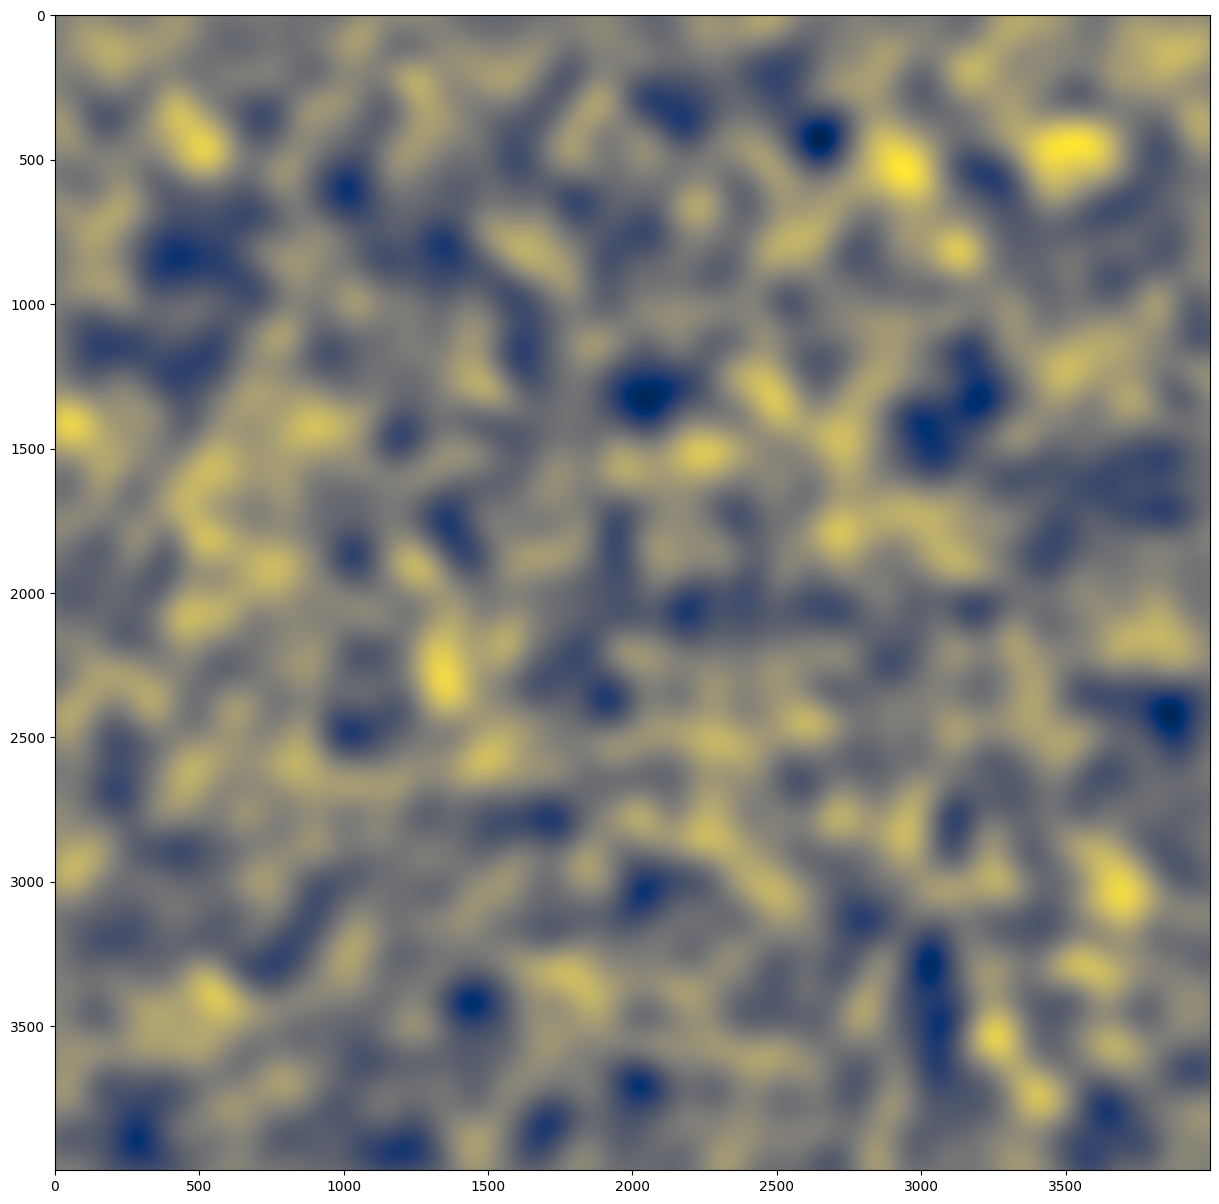

In [6]:
sim_matrix = create_simultated_matrix(2000, 4000)
plt.imshow(sim_matrix, cmap = "cividis")

Lets generate the quadtree for the above sim data

In [7]:
%%time
quadtree = RegionQuadTree(
                    array = sim_matrix,
                    split_func = smape_numba, # Our splitting criteria function
                    split_thresh = 5, # The threshold (T) to determine splitting. In this case it is 5% error 
                    max_depth = 9, # Maximum depth to recurse
            ) 

CPU times: user 1.31 s, sys: 99.1 ms, total: 1.41 s
Wall time: 1.41 s


In [8]:
inspect(quadtree)

╭──────────── <class 'pyquad.region_quadtree.RegionQuadTree'> ─────────────╮
│ Interface for region quadtree                                            │
│                                                                          │
│ ╭──────────────────────────────────────────────────────────────────────╮ │
│ │ <pyquad.region_quadtree.RegionQuadTree object at 0x13f2933a0>        │ │
│ ╰──────────────────────────────────────────────────────────────────────╯ │
│                                                                          │
│    max_depth = 9                                                         │
│         root = <pyquad.region_quadtree.RegionNode object at 0x13f265f60> │
│ split_thresh = 5                                                         │
╰──────────────────────────────────────────────────────────────────────────╯

The tree can be accessed directly through the `root` class variable

In [9]:
inspect(quadtree.root)

╭─────────────── <class 'pyquad.region_quadtree.RegionNode'> ────────────────╮
│ Node class for region quadtree                                             │
│                                                                            │
│ ╭────────────────────────────────────────────────────────────────────────╮ │
│ │ <pyquad.region_quadtree.RegionNode object at 0x13f265f60>              │ │
│ ╰────────────────────────────────────────────────────────────────────────╯ │
│                                                                            │
│   bounding_box = BoundingBox(lx=0, rx=4000, ty=0, by=4000)                 │
│       children = 0                                                         │
│           data = None                                                      │
│          depth = 0                                                         │
│           leaf = False                                                     │
│             ne = <pyquad.region_quadtree.RegionNode object at 0x13ef54100> │
│             nw = <pyquad.region_quadtree.RegionNode object at 0x13f2d3eb0> │
│             se = <pyquad.region_quadtree.RegionNode object at 0x105e01030> │
│ split_criteria = 94.97918971726756                                         │
│             sw = <pyquad.region_quadtree.RegionNode object at 0x105e00250> │
│            val = 94.97918971726756                                         │
╰────────────────────────────────────────────────────────────────────────────╯

Lets plot! (I apologize but plotting is very slow at the moment, especially for scenes with lots of variation if values, e.g. floats)

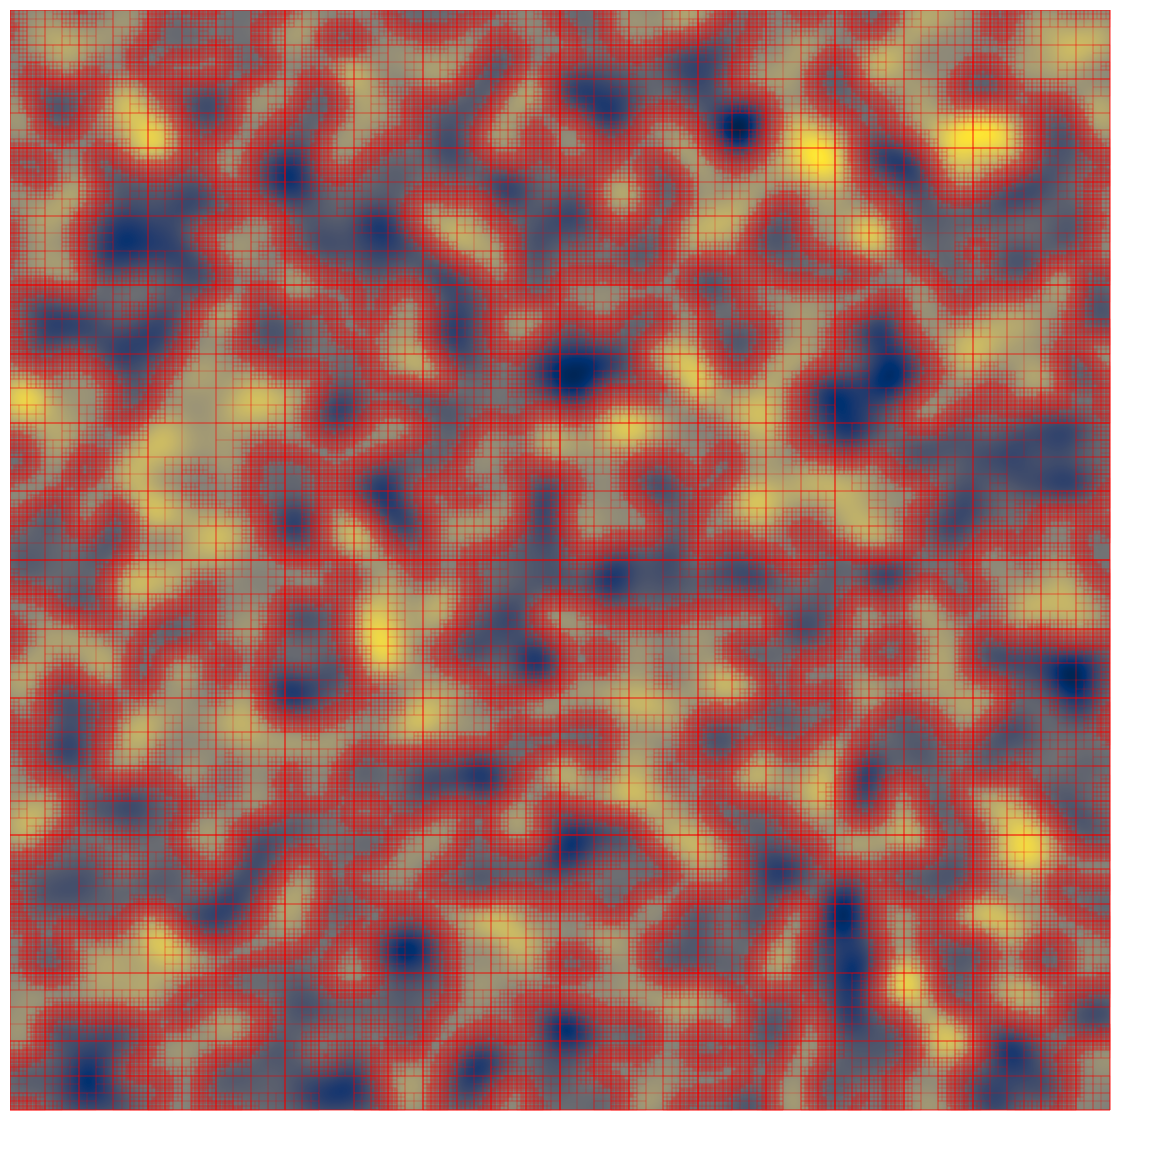

In [10]:
ax = plt.subplot()
ax.imshow(sim_matrix, cmap = "cividis") # Base plot of original matrix
quadtree.draw(ax, c = "red") # Plot all nodes
plt.axis('off')
plt.show()

Now lets add some artifical objects of uniform areas into our simulated matrix and generate the quadtree again

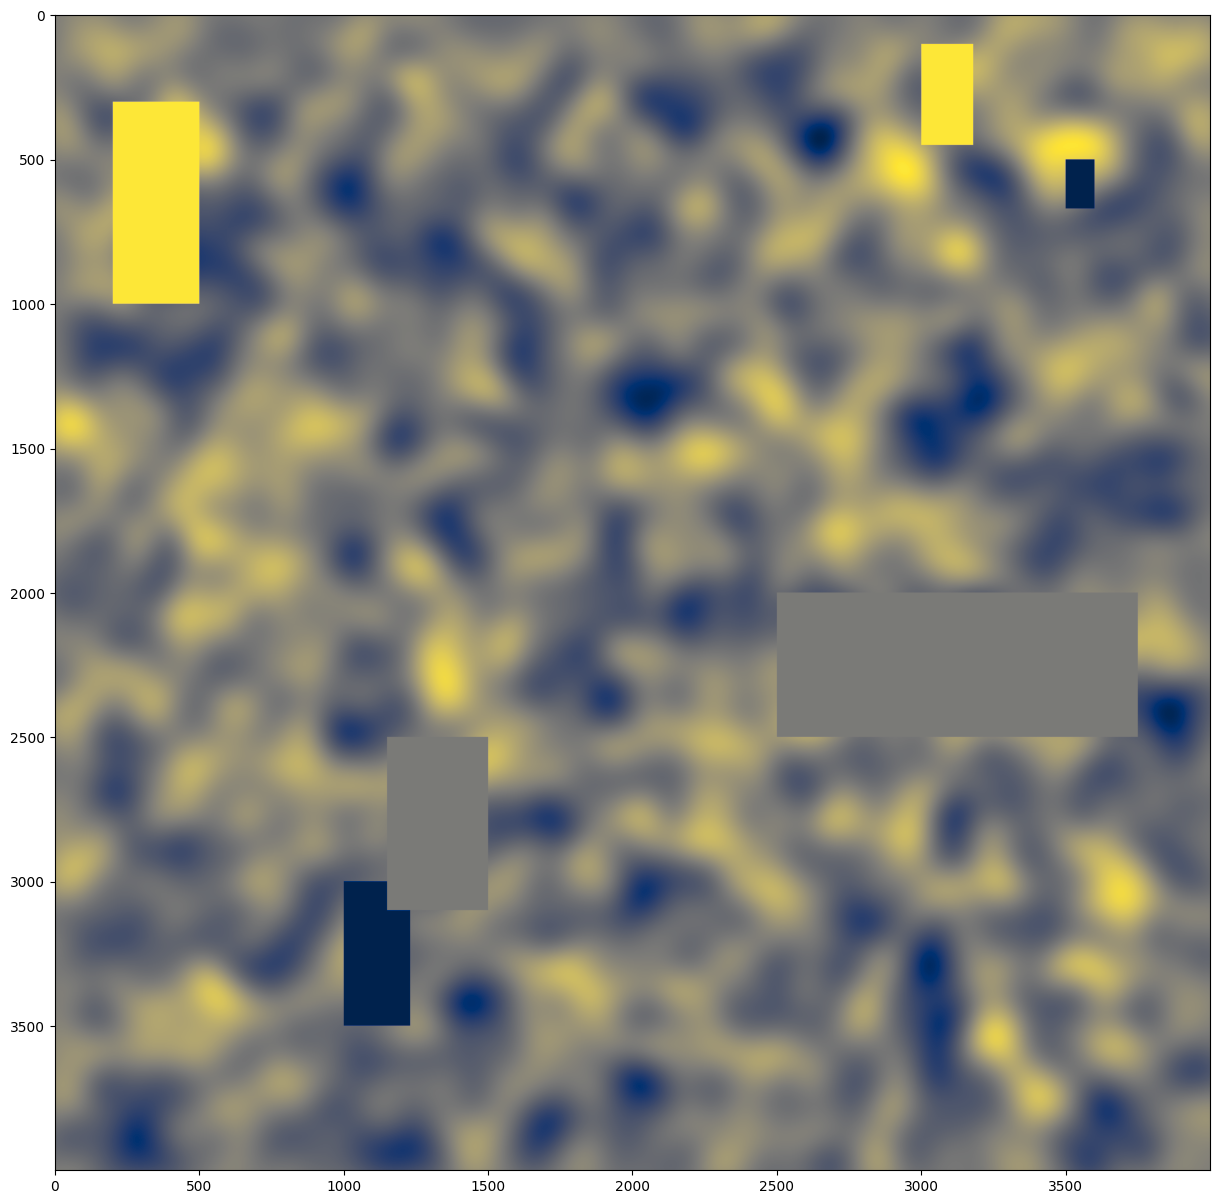

In [11]:
sim_matrix[300:1000, 200: 500] = sim_matrix.max()
sim_matrix[2000:2500, 2500:3750] = sim_matrix.mean()
sim_matrix[100:450, 3000:3180] = sim_matrix.max()
sim_matrix[3000:3500, 1000:1230] = sim_matrix.min()
sim_matrix[2500:3100, 1150:1500] = sim_matrix.mean()
sim_matrix[500:670, 3500:3600] = sim_matrix.min()
plt.imshow(sim_matrix, cmap = "cividis")

In [12]:
%%time
quadtree = RegionQuadTree(
                    array = sim_matrix,
                    split_func = smape_numba, # Our splitting criteria function
                    split_thresh = 5, # The threshold (T) to determine splitting. In this case it is 5% error 
                    max_depth = 9, # Maximum depth to recurse
            ) 

CPU times: user 768 ms, sys: 82.5 ms, total: 851 ms
Wall time: 850 ms


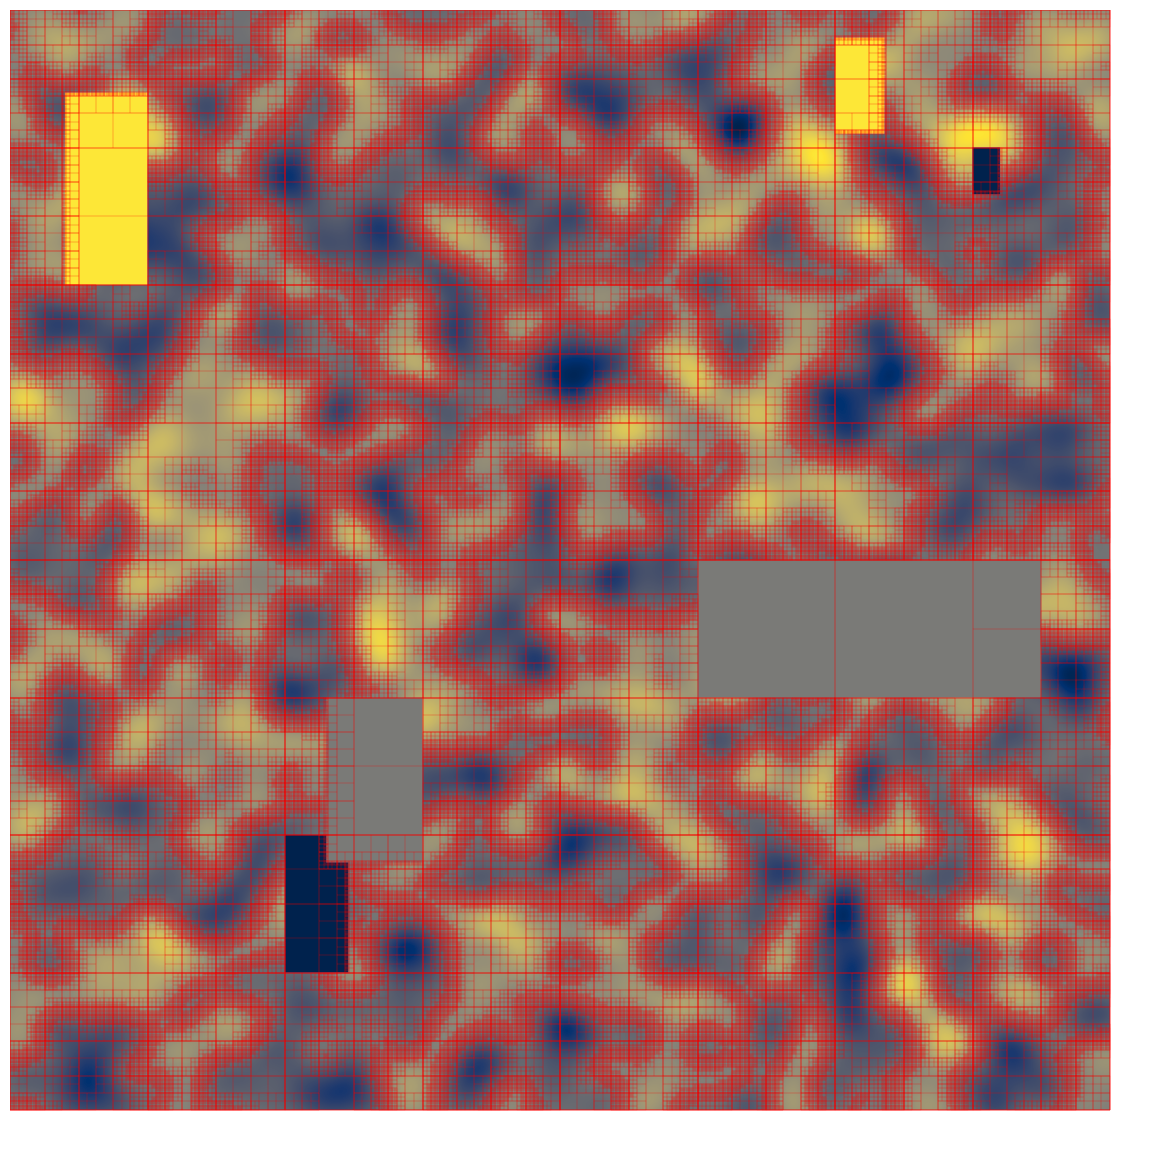

In [13]:
ax = plt.subplot()
ax.imshow(sim_matrix, cmap = "cividis") # Base plot of original matrix
quadtree.draw(ax, c = "red") # Plot all nodes
plt.axis('off')
plt.show()